In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from data.data import Data
from data.funcs import g0, m0
from models.coupled_machine_learning import CoupledMachineLearning
#from tqdm.notebook import tqdm
from tqdm import tqdm
from wrap.stats import est_theta
from wrap.utils import torch_to_np, train_test_split

%load_ext autoreload
%autoreload 2

p = 20
n = 1000
rho = 0
theta = 1
lamb = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


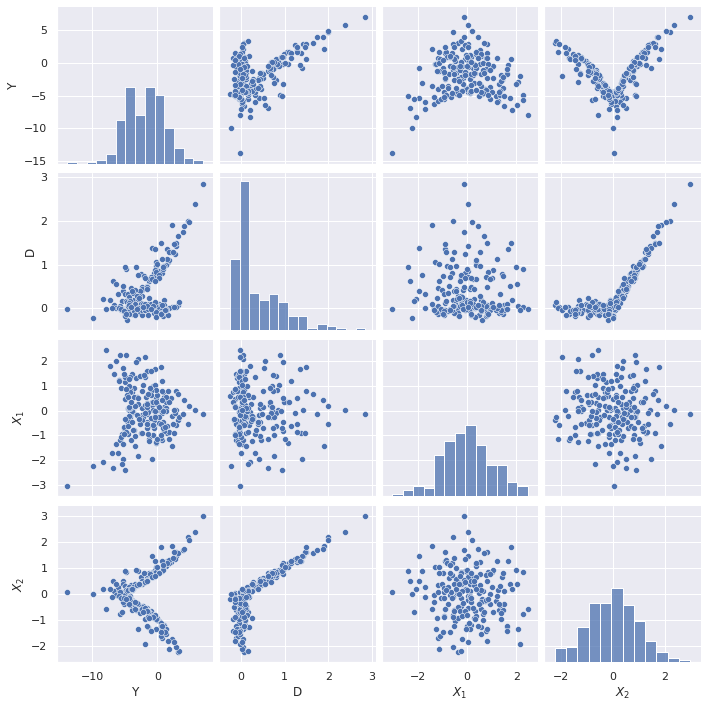

In [40]:
true_model = Data(p, rho, theta, lamb)

n_plot = 200
Y, D, X = true_model.generate(n_plot)
Y, D, X = torch_to_np(Y), torch_to_np(D), torch_to_np(X)

df = pd.DataFrame(data=np.concatenate((Y.reshape(n_plot, 1), D.reshape(n_plot, 1), X[:, 0:2]), 1), 
                  columns=['Y', 'D', '$X_1$', '$X_2$'])
sns.set(font_scale=1)
sns.pairplot(df)
sns.set(rc={'figure.figsize': (10, 10)})
plt.savefig('results/pairs_' + str(theta) + '_.pdf', bbox_inches="tight")
plt.show()

## Debugging

In [77]:
from models.coupled_machine_learning import CoupledMachineLearning

gamma = 0.9

true_model = Data(p, rho, theta, lamb)
y, d, x = true_model.generate(n)
train, test = train_test_split(y, d, x)
            
# Estimate l_hat + m_hat
bbox = CoupledMachineLearning(true_model, train['x'].shape[1]+1, hidden_dims=(32, 32, 32),
                              activation_params=dict(negative_slope=0.1))


_, dm, dl = bbox.fit(train['x'], train['d'], train['y'], reg_labmda=gamma,
                     batch_size=100, max_epochs=1000, lr=0.001)

m_hat, l_hat = bbox.predict(test['x'], test['d'])

In [78]:
print(np.mean(dm*dm))
print(np.mean(dl*dl))
print(np.corrcoef(dm, dl))

0.016593533
0.092493944
[[1.        0.0282097]
 [0.0282097 1.       ]]


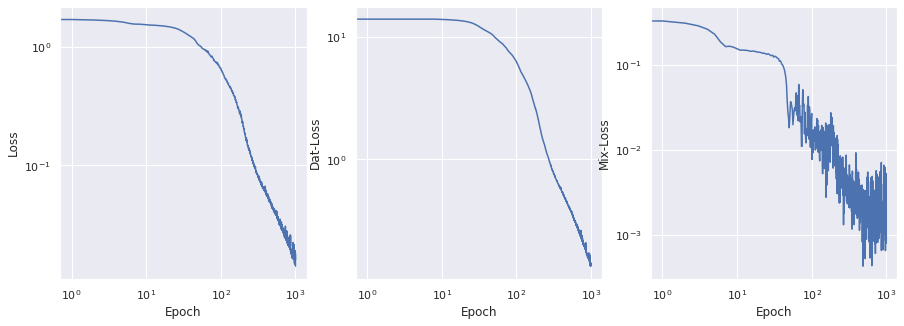

In [79]:
history = pd.DataFrame(bbox.history).groupby('Epoch').mean().reset_index()

fig, axs = plt.subplots(1,3, figsize=(15, 5))

axs[0].plot(history['Epoch'], history['Loss'])
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_xscale("log")
axs[0].set_yscale("log")

axs[1].plot(history['Epoch'], history['Dat-Loss'])
axs[1].set_ylabel("Dat-Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_xscale("log")
axs[1].set_yscale("log")

axs[2].plot(history['Epoch'], history['Mix-Loss'])
axs[2].set_ylabel("Mix-Loss")
axs[2].set_xlabel("Epoch")
axs[2].set_xscale("log")
axs[2].set_yscale("log")

plt.show()

## Experiments

In [80]:
def run_experiments(theta, gammas, num_exp=10):
    lamb = 1.
    df = pd.DataFrame()
    for gamma in tqdm(gammas):
        for i in range(num_exp):
            true_model = Data(p, rho, theta, lamb)
            y, d, x = true_model.generate(n)
            train, test = train_test_split(y, d, x)
            
            # Estimate l_hat + m_hat
            bbox = CoupledMachineLearning(true_model, train['x'].shape[1]+1, hidden_dims=(32, 32, 32),
                                      activation_params=dict(negative_slope=0.1))
            _, dm, dl = bbox.fit(train['x'], train['d'], train['y'], reg_labmda=gamma, max_epochs=1000)
            m_hat, l_hat = bbox.predict(test['x'], test['d'])
            
            # Statistics
            theta_hat, v2 = est_theta(test['y'], test['d'], m_hat, l_hat)
            
            df_tmp = pd.DataFrame({
                'model' : ['mlp'],
                'rho' : rho,
                'lamb' : lamb,
                'theta' : theta,
                'dtheta' : theta_hat - theta,
                'gamma' : gamma,
                'dm.2' : np.mean(dm ** 2),
                'dl.2' : np.mean(dl ** 2),
                'dm.dl': np.corrcoef(dm, dl)[0,1],  
            })
            df = pd.concat([df, df_tmp])
    
    return df

In [81]:
gammas = np.asarray([0, 0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999, 1])
df = run_experiments(theta, gammas, num_exp=2)
df_avg = df.groupby(['model', 'rho', 'gamma', 'theta']).mean().reset_index()


100%|██████████| 9/9 [06:08<00:00, 41.18s/it]

In [ ]:
# def plot_results(df, axs, key):
#     for gamma in gammas:
#         df_tmp = df[df['gamma'] == gamma]
#         df_tmp[key].plot.hist(alpha=0.5, ax=axs, label='{:.1e}'.format(gamma))     

In [ ]:
# fig = plt.figure(figsize=(10,10))
# grid = fig.add_gridspec(2, 2)

# axs = fig.add_subplot(grid[0,0])
# plot_results(df, axs, 'dm.2')
# axs.set_title('$(\\Delta m)^2$')
# axs.legend()
# axs.axvline(x=0, linestyle='--', linewidth=2., color='red')

# axs = fig.add_subplot(grid[0,1])
# plot_results(df, axs, 'dl.2')
# axs.set_title('$(\\Delta l)^2$')
# axs.legend()
# axs.axvline(x=0, linestyle='--', linewidth=2., color='red')

# axs = fig.add_subplot(grid[1,:])
# plot_results(df, axs, 'dm.dl')
# axs.set_title('$\\Delta m \cdot \\Delta l$')
# axs.legend()
# axs.axvline(x=0, linestyle='--', linewidth=2., color='red')

# plt.savefig('results/diagnostic_internal_' + str(theta) + '_.pdf', bbox_inches='tight')
# plt.show()

In [82]:
def get_val(df, key):
    val = []
    for gamma in gammas:
        df_tmp = df[df['gamma'] == gamma]
        val.append(df_tmp[key].mean())
    return np.asarray(val)

dm_2 = get_val(df, 'dm.2')
dl_2 = get_val(df, 'dl.2')
dm_dl = get_val(df, 'dm.dl')

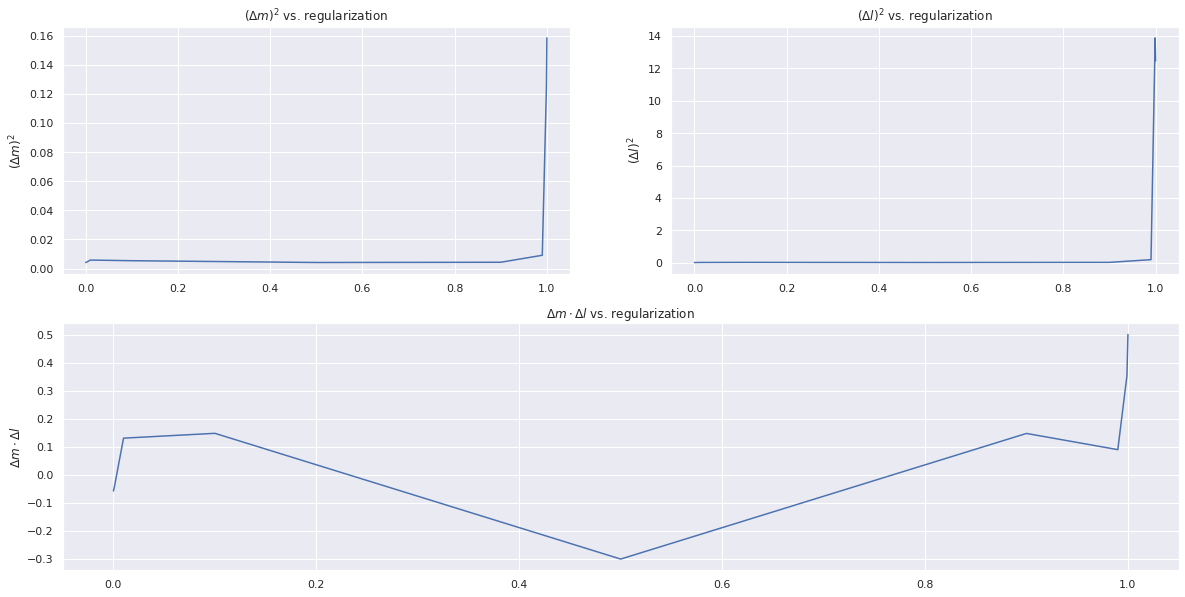

In [83]:
fig = plt.figure(figsize=(20, 10))
grid = fig.add_gridspec(2, 2)

axs = fig.add_subplot(grid[0, 0])
axs.plot(gammas, dm_2)
# axs.set_xscale('log')
axs.set_title('$(\\Delta m)^2$')
axs.set_ylabel('$(\\Delta m)^2$')
axs.set_title('$(\\Delta m)^2$ vs. regularization')

axs = fig.add_subplot(grid[0, 1])
axs.plot(gammas, dl_2)
# axs.set_xscale('log')
axs.set_title('$(\\Delta l)^2$')
axs.set_ylabel('$(\\Delta l)^2$')
axs.set_title('$(\\Delta l)^2$ vs. regularization')

axs = fig.add_subplot(grid[1, :])
axs.plot(gammas, dm_dl)
# axs.set_xscale('log')
axs.set_title('$\\Delta m \cdot \\Delta l$')
axs.set_ylabel('$\\Delta m \cdot \\Delta l$')
axs.set_title('$\\Delta m \cdot \\Delta l$ vs. regularization')

plt.savefig('results/diagnostic_internal_reg_' + str(theta) + '_.pdf', bbox_inches='tight')
plt.show()

In [ ]:
def get_bias(df):
    bias = []
    for gamma in gammas:
        df_tmp = df[df['gamma'] == gamma]
        bias.append(df_tmp['dtheta'].mean())
    return np.asarray(bias)

def get_variance(df):
    variance = []
    for gamma in gammas:
        df_tmp = df[df['gamma'] == gamma]
        variance.append(df_tmp['dtheta'].var())
    return np.asarray(variance)

bias = get_bias(df) 
variance = get_variance(df)

In [ ]:
fig = plt.figure(figsize=(20, 10))
grid = fig.add_gridspec(2, 2)

axs = fig.add_subplot(grid[0, 0])
axs.plot(gammas, bias)
# axs.set_xscale('log')
axs.set_xlabel('$\\gamma$')
axs.set_ylabel('Bias')
axs.set_title('Bias vs. regularization')

axs = fig.add_subplot(grid[0, 1])
axs.plot(gammas, variance)
# axs.set_xscale('log')
axs.set_xlabel('$\\gamma$')
axs.set_ylabel('Variance')
axs.set_title('Variance vs. regularization')


axs = fig.add_subplot(grid[1, :])
axs.plot(gammas, bias ** 2 + variance)
# axs.set_xscale('log')
axs.set_xlabel('$\\gamma$')
axs.set_ylabel('Bias$^2$ + Variance')
axs.set_title('Bias$^2$ + Variance vs. regularization')

plt.savefig('results/diagnostic_external_' + str(theta) + '_.pdf', bbox_inches='tight')
plt.show()

In [ ]:
def run_experiments(theta, gammas, num_exp=10):
    lamb = 1.
    df = pd.DataFrame()
    for gamma in tqdm(gammas):
        for i in range(num_exp):
            true_model = Data(p, rho, theta, lamb)
            y, d, x = true_model.generate(n)
            train, test = train_test_split(y, d, x)
            
            # Estimate l_hat + m_hat
            bbox = CoupledMachineLearning(true_model, train['x'].shape[1]+1, hidden_dims=(32, 32, 32),
                                      activation_params=dict(negative_slope=0.1))
            _, dm, dl = bbox.fit(train['x'], train['d'], train['y'], reg_labmda=gamma)
            m_hat, l_hat = bbox.predict(test['x'], test['d'])
            
            # Statistics
            y, d, x = true_model.generate(n)
            m_hat, l_hat = bbox.predict(x, d)
            
            true_m = m0(x, lamb)
            true_l = g0(x) + theta * true_m
            
            dm_mse = ((true_m - m_hat) ** 2).mean().item()
            dl_mse = ((true_l - l_hat) ** 2).mean().item()
            
            df_tmp = pd.DataFrame({
                'model' : ['mlp'],
                'rho' : rho,
                'lamb' : lamb,
                'theta' : theta,
                'gamma' : gamma,
                'dm.mse' : dm_mse,
                'dl.mse' : dl_mse 
            })
            df = pd.concat([df, df_tmp])
    
    return df

In [ ]:
gammas = np.asarray([0, 0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999, 1])
df = run_experiments(theta, gammas, num_exp=100)
df_avg = df.groupby(['model', 'rho', 'gamma', 'theta']).mean().reset_index()

In [ ]:
def get_val(df, key):
    val = []
    for gamma in gammas:
        df_tmp = df[df['gamma'] == gamma]
        val.append(df_tmp[key].mean())
    return np.asarray(val)

dm_mse = get_val(df, 'dm.mse')
dl_mse = get_val(df, 'dl.mse')

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(gammas, dm_mse)
# axs[0].set_xscale('log')
axs[0].set_xlabel('$\\gamma$')
axs[0].set_ylabel('MSE($\\Delta m$)')
axs[0].set_title('MSE($\\Delta m$) vs. regularization')

axs[1].plot(gammas, dl_mse)
# axs[1].set_xscale('log')
axs[1].set_xlabel('$\\gamma$')
axs[1].set_ylabel('MSE($\\Delta l$)')
axs[1].set_title('MSE($\\Delta l$) vs. regularization')

plt.subplots_adjust(hspace=0.3)
plt.savefig('results/diagnostic_mse_' + str(theta) + '_.pdf', bbox_inches='tight')
plt.show()